'''
We are learning how to use LSTM to do forecasting. Follow the code and explain it when it is needed.
'''

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

%matplotlib widget

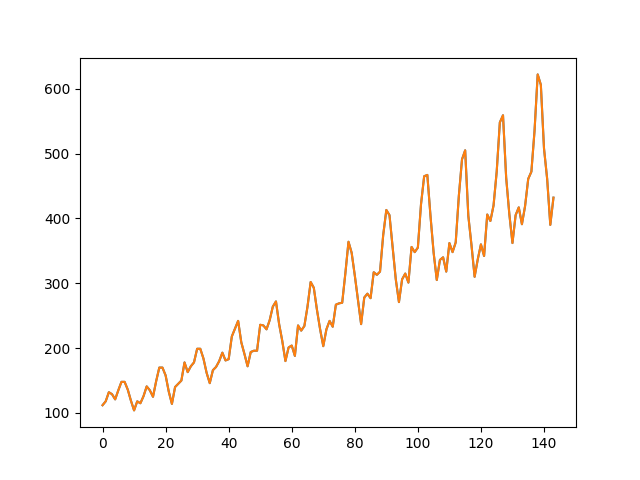

In [7]:
#load the dataset

training_set = pd.read_csv('airline-passengers.csv')

training_set = training_set.iloc[:,1:2].values

plt.plot(training_set, label = 'Airlines Data')
plt.show()

In [8]:
'''
***Explain*** What is the sliding_windows function doing here?, and what does the seq_length value mean?
'''

seq_length = 5

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)



sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [9]:
'''
LSTM Network
'''

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        '''
        ***Explain*** Why do we need h_0 and c_0?
        '''
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [10]:
num_epochs = 5000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1

'''
***Explain*** Why are the input size and the num_classes equal to one?, should not it be input_size = seq_length? 
'''

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

# for np in lstm.parameters():
#     print(np)

In [13]:


criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
def train(criterion, optimizer, lstm, num_epochs):
  # Train the model
  for epoch in range(num_epochs):
      outputs = lstm(trainX)
      optimizer.zero_grad()
      
      # obtain the loss function
      loss = criterion(outputs, trainY)
      loss.backward()
      optimizer.step()
      if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

train(criterion, optimizer, lstm, 5000)

Epoch: 0, loss: 0.00171
Epoch: 100, loss: 0.00169
Epoch: 200, loss: 0.00165
Epoch: 300, loss: 0.00160
Epoch: 400, loss: 0.00156
Epoch: 500, loss: 0.00154
Epoch: 600, loss: 0.00151
Epoch: 700, loss: 0.00149
Epoch: 800, loss: 0.00149
Epoch: 900, loss: 0.00150
Epoch: 1000, loss: 0.00142
Epoch: 1100, loss: 0.00132
Epoch: 1200, loss: 0.00131
Epoch: 1300, loss: 0.00130
Epoch: 1400, loss: 0.00129
Epoch: 1500, loss: 0.00129
Epoch: 1600, loss: 0.00128
Epoch: 1700, loss: 0.00127
Epoch: 1800, loss: 0.00126
Epoch: 1900, loss: 0.00128
Epoch: 2000, loss: 0.00125
Epoch: 2100, loss: 0.00131
Epoch: 2200, loss: 0.00123
Epoch: 2300, loss: 0.00123
Epoch: 2400, loss: 0.00122
Epoch: 2500, loss: 0.00122
Epoch: 2600, loss: 0.00121
Epoch: 2700, loss: 0.00120
Epoch: 2800, loss: 0.00120
Epoch: 2900, loss: 0.00118
Epoch: 3000, loss: 0.00117
Epoch: 3100, loss: 0.00114
Epoch: 3200, loss: 0.00110
Epoch: 3300, loss: 0.00105
Epoch: 3400, loss: 0.00100
Epoch: 3500, loss: 0.00093
Epoch: 3600, loss: 0.00092
Epoch: 3700, 

## Testing for Airplane Passengers Dataset

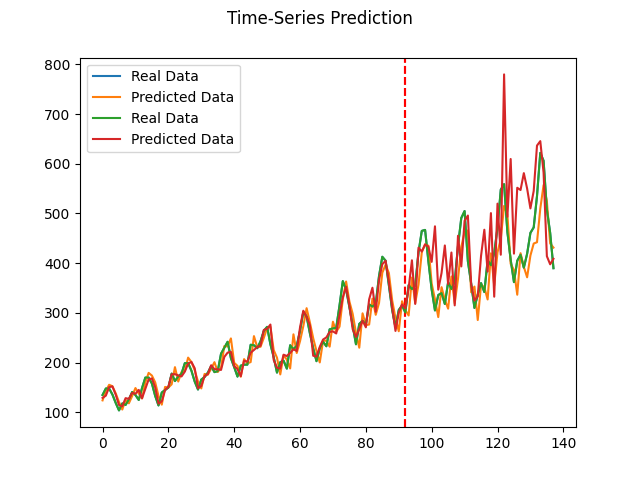

In [14]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#Plot the Predictions

plt.figure(2)
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label='Real Data')
plt.plot(data_predict, label='Predicted Data')
plt.suptitle('Time-Series Prediction')

plt.legend()
plt.show()

In [9]:
'''
***Explain Rerun*** your model with 5000 epochs. Do you notice something strange? If yes, provide an explanation.
'''

'\n***Explain Rerun*** your model with 5000 epochs. Do you notice something strange? If yes, provide an explanation.\n'

In [24]:
'''
Implement MSE calculation for the test data
'''

def evaluate_loss(sc, lstm, loss, testX, testY):
    lstm.eval()
    predict = lstm(testX)

    data_predict = predict.detach().numpy()
    data_real = testY.detach().numpy()

    data_predict = torch.tensor(sc.inverse_transform(data_predict))
    data_real = torch.tensor(sc.inverse_transform(data_real))

    return loss(data_predict, data_real).item()

In [25]:
sequence_lengths = [8, 10, 12]
hidden_sizes = [5, 8, 10]

predictions = [dataY_plot.flatten()]
errors = []
parameters = []

for seq_length in sequence_lengths:
    sc = MinMaxScaler()
    training_data = sc.fit_transform(training_set)

    x, y = sliding_windows(training_data, seq_length)

    train_size = int(len(y) * 0.67)
    test_size = len(y) - train_size

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
    for hidden_size in hidden_sizes:
        parameters.append((seq_length, hidden_size))
        lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
        criterion = torch.nn.MSELoss()    
        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

        train(criterion, optimizer, lstm, 2000)
        with torch.no_grad():
            pred = lstm(dataX)
            predictions.append(sc.inverse_transform(pred.data.numpy()).flatten())

        errors.append(evaluate_loss(sc, lstm, criterion, testX, testY))

        

Epoch: 0, loss: 0.05924
Epoch: 100, loss: 0.00324
Epoch: 200, loss: 0.00255
Epoch: 300, loss: 0.00193
Epoch: 400, loss: 0.00162
Epoch: 500, loss: 0.00151
Epoch: 600, loss: 0.00143
Epoch: 700, loss: 0.00120
Epoch: 800, loss: 0.00108
Epoch: 900, loss: 0.00102
Epoch: 1000, loss: 0.00095
Epoch: 1100, loss: 0.00086
Epoch: 1200, loss: 0.00074
Epoch: 1300, loss: 0.00063
Epoch: 1400, loss: 0.00056
Epoch: 1500, loss: 0.00051
Epoch: 1600, loss: 0.00047
Epoch: 1700, loss: 0.00045
Epoch: 1800, loss: 0.00042
Epoch: 1900, loss: 0.00040
Epoch: 0, loss: 0.10969
Epoch: 100, loss: 0.00368
Epoch: 200, loss: 0.00247
Epoch: 300, loss: 0.00169
Epoch: 400, loss: 0.00159
Epoch: 500, loss: 0.00155
Epoch: 600, loss: 0.00152
Epoch: 700, loss: 0.00147
Epoch: 800, loss: 0.00141
Epoch: 900, loss: 0.00137
Epoch: 1000, loss: 0.00139
Epoch: 1100, loss: 0.00117
Epoch: 1200, loss: 0.00110
Epoch: 1300, loss: 0.00104
Epoch: 1400, loss: 0.00099
Epoch: 1500, loss: 0.00059
Epoch: 1600, loss: 0.00058
Epoch: 1700, loss: 0.0004

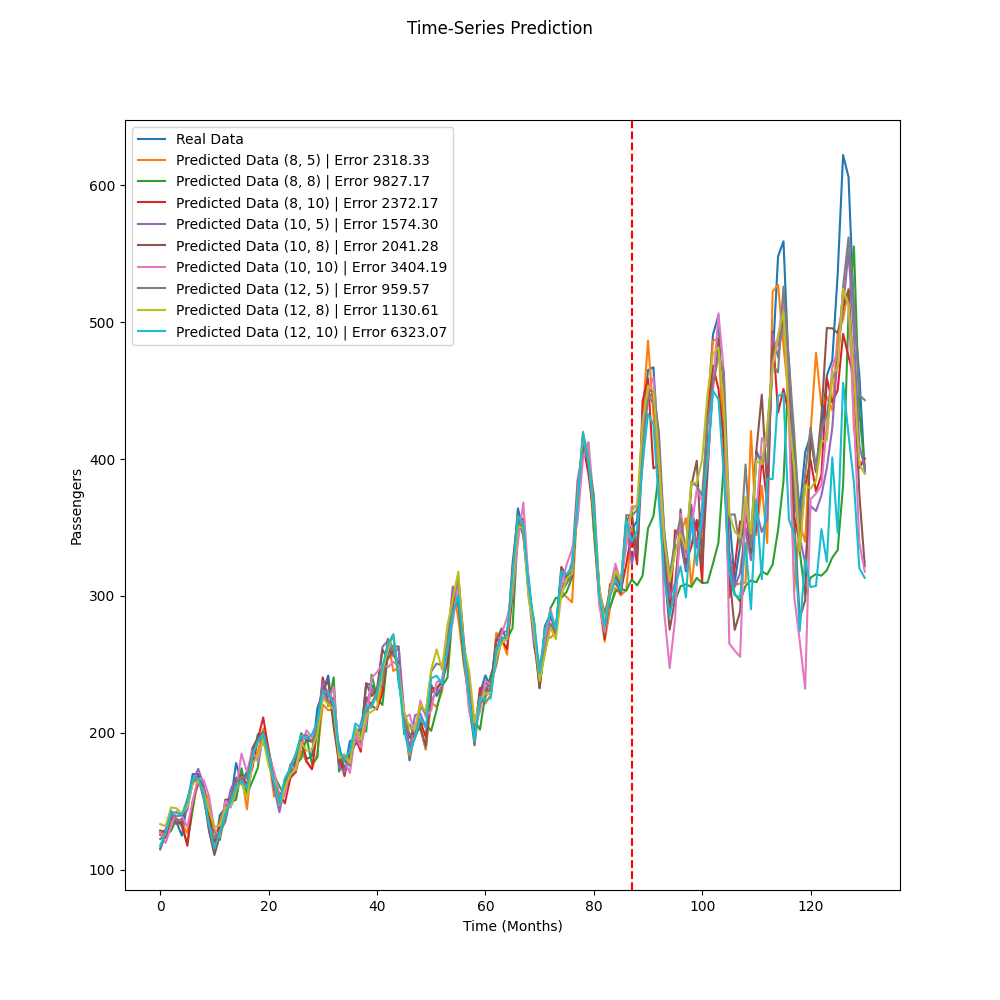

In [20]:
plt.figure(3, figsize=(10, 10))
plt.clf()
plt.figure(3, figsize=(10, 10))
plt.axvline(x=train_size, c='r', linestyle='--')

shortest_len = len(predictions[-1])

plt.plot(predictions[0][len(predictions[0]) - shortest_len:], label='Real Data')

for pred, params, error in zip(predictions[1:], parameters, errors) :
    plt.plot(pred[len(pred)-shortest_len:], label=f'Predicted Data {str(params)} | Error {error:.2f}')

plt.xlabel('Time (Months)')
plt.ylabel('Passengers')
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()